In [65]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import models, layers

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

We set the batch_size 32 so all the images are stored in the batch size of 32, 

length of the dataset = total images / batch size
length of the dataset = 2152 / 32
length of the dataset = 67.25 = 68

In [6]:
for image_batch, leble_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


Shape of the 1st image is 256 x 256 and 3 is chennal color, which is RGB.

In [7]:
for image_batch, leble_batch in dataset.take(1):
    print(image_batch[0]) # image is in tensor, the shape is 256 x 256

tf.Tensor(
[[[173. 168. 172.]
  [159. 154. 158.]
  [172. 167. 171.]
  ...
  [130. 120. 119.]
  [139. 129. 128.]
  [124. 114. 113.]]

 [[195. 190. 194.]
  [183. 178. 182.]
  [188. 183. 187.]
  ...
  [130. 120. 119.]
  [137. 127. 126.]
  [118. 108. 107.]]

 [[191. 186. 190.]
  [181. 176. 180.]
  [182. 177. 181.]
  ...
  [132. 122. 121.]
  [145. 135. 134.]
  [132. 122. 121.]]

 ...

 [[173. 165. 163.]
  [172. 164. 162.]
  [167. 159. 157.]
  ...
  [130. 118. 118.]
  [140. 128. 128.]
  [127. 115. 115.]]

 [[171. 163. 161.]
  [171. 163. 161.]
  [168. 160. 158.]
  ...
  [120. 108. 108.]
  [123. 111. 111.]
  [114. 102. 102.]]

 [[165. 157. 155.]
  [169. 161. 159.]
  [172. 164. 162.]
  ...
  [135. 123. 123.]
  [133. 121. 121.]
  [127. 115. 115.]]], shape=(256, 256, 3), dtype=float32)


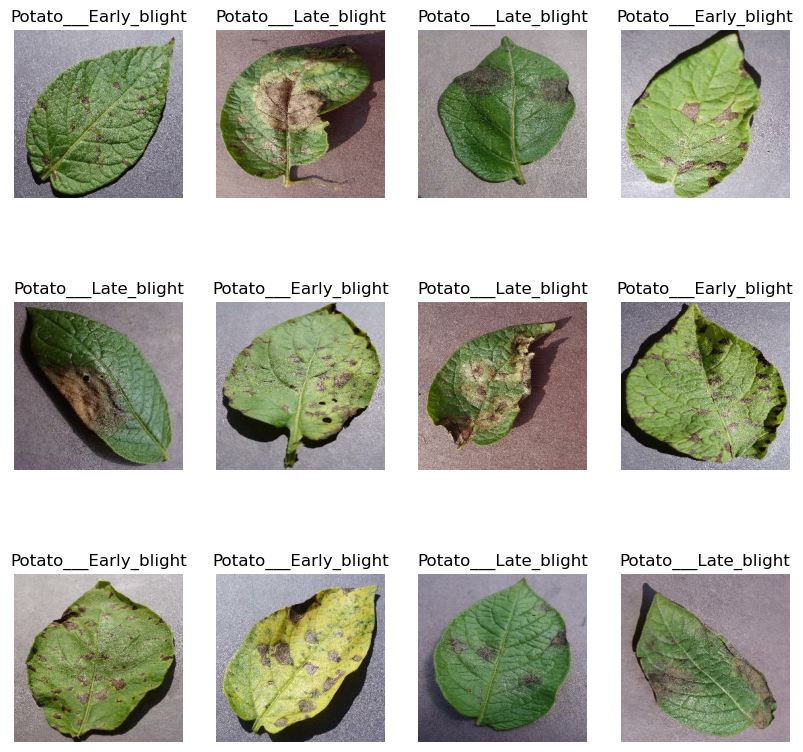

In [8]:
plt.figure(figsize=(10,10))

for image_batch, leble_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[leble_batch[i]])
        plt.axis("off")

## Splitting the data

In [9]:
EPOCH = 50

80% = training
10% = validation
10% = test

In [10]:
# Getting actual number of training data
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [11]:
# first 54 are training data
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
# Other data is for testing and validation
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
# Splitting 10% for validation
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
# actual test dataset
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split=0.1, test_split=0.1, shuffle = True, shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)



    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

len(val_ds)

In [18]:
# Optimize datasets so machine could run faster
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
# For final model we need images in 256 x 256; if user gives any image other than this dimention we need to resize it
# Creating a layer for resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augmentation

In [20]:
# Creating a layer for flip and rotation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Model Building

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    #Input Layer
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),

    #Filter Layers
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [23]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs = EPOCH,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
54/54 [==============================] - 61s 1s/step - loss: 0.8656 - accuracy: 0.5012 - val_loss: 0.6221 - val_accuracy: 0.7292
Epoch 2/50
54/54 [==============================] - 56s 1s/step - loss: 0.5779 - accuracy: 0.7332 - val_loss: 0.4080 - val_accuracy: 0.8177
Epoch 3/50
54/54 [==============================] - 56s 1s/step - loss: 0.4411 - accuracy: 0.8056 - val_loss: 0.3886 - val_accuracy: 0.8490
Epoch 4/50
54/54 [==============================] - 56s 1s/step - loss: 0.3371 - accuracy: 0.8605 - val_loss: 0.3770 - val_accuracy: 0.8281
Epoch 5/50
54/54 [==============================] - 56s 1s/step - loss: 0.2754 - accuracy: 0.8900 - val_loss: 0.5848 - val_accuracy: 0.7240
Epoch 6/50
54/54 [==============================] - 56s 1s/step - loss: 0.2112 - accuracy: 0.9172 - val_loss: 1.0720 - val_accuracy: 0.5104
Epoch 7/50
54/54 [==============================] - 56s 1s/step - loss: 0.2353 - accuracy: 0.9086 - val_loss: 0.4024 - val_accuracy: 0.8333
Epoch 8/50
54/54 [==

In [25]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 230ms/step - loss: 0.0568 - accuracy: 0.9766


In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
len(history.history['accuracy'])

50

In [32]:
# storing params for plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

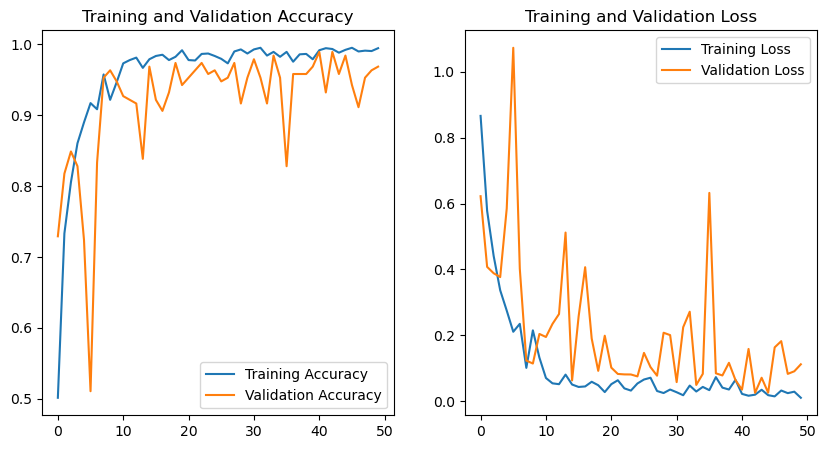

In [43]:
# Plotting the params

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(range(EPOCH), acc, label = "Training Accuracy")
plt.plot(range(EPOCH), val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCH), loss, label = "Training Loss")
plt.plot(range(EPOCH), val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")

plt.show()

### Prediction

First image to predict
Actual label:  Potato___Late_blight
1/1 [==============================] - 0s 218ms/step
Predicted label:  Potato___Late_blight


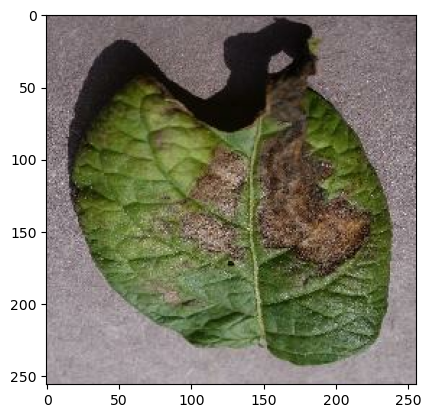

In [48]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label: ", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [59]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 28ms/step


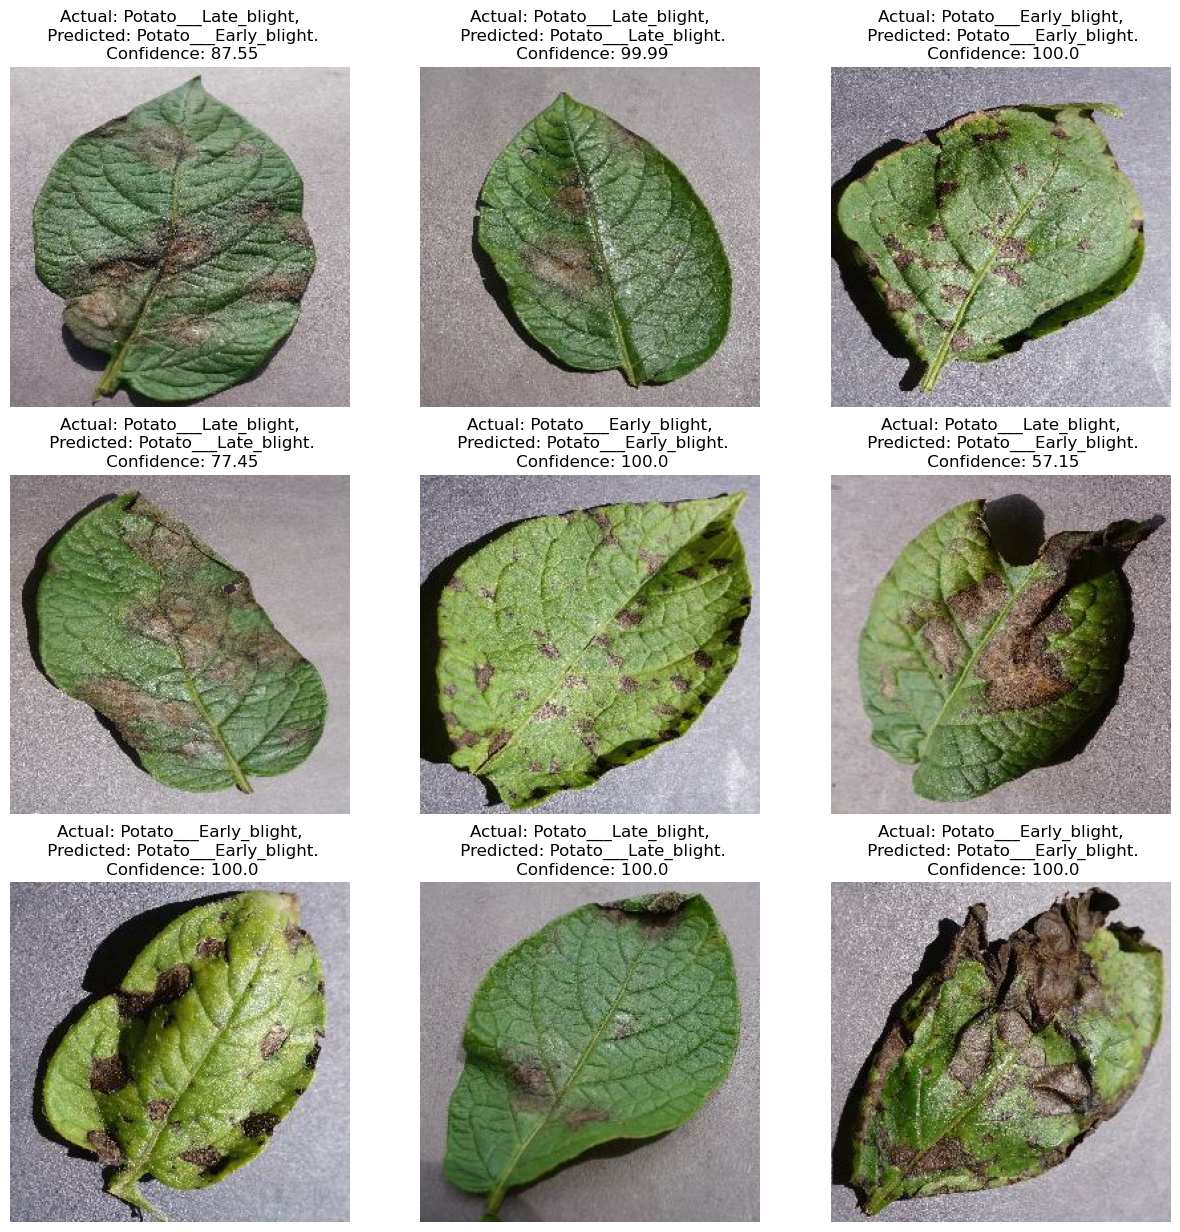

In [62]:
plt.figure(figsize = (15,15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}")
        
        plt.axis('off')

Model_saving

In [67]:
# Setting up the autoincrement system for model versions

model_version = max([int(i) for i in os.listdir("Models") + [0]]) + 1
model_version

2

In [ ]:
# Saving a final model with updated version
model.save(f"Models/{model_version}")